In [1]:
import pandas as pd
import numpy as np

# Machine learning
import torch
import mindsdb_native as mdb


import os
import time

S3 Datasource is not available by default. If you wish to use it, please install mindsdb_native[extra_data_sources]
Athena Datasource is not available by default. If you wish to use it, please install mindsdb_native[extra_data_sources]
Google Cloud Storage Datasource is not available by default. If you wish to use it, please install mindsdb_native[extra_data_sources]


pip3 install mindsdb_native --upgrade



In [2]:
# Setup torch seed for reproducibility
torch.manual_seed(1234)

## 1) Load the dataset

For simplicity in training (as the stanford dataset is quite large), we'll use a tripadvisor hotel review dataset.
The goal of this dataset is to be able to predict the rating (1-5 stars, with 1 being the lowest and 5 being the highest) of the hotel, given an arbitary review.

In [3]:
%ls datasets/

stanford_movie_review/  tripadvisor/


In [4]:
data_dir = "datasets/"
dataset = "tripadvisor"
filename = os.path.join(data_dir, dataset, "data.csv")


# Load the data, and scramble the order. The way the data has been 
data = pd.read_csv(filename).sample(frac=1, random_state=42)

data.head()

,Review,Rating
10726,not recommend hotel did reviewers actually sta...,1
14919,"barcelona rocks, stayed hotel jazz girlfriend ...",4
19098,ok hotel good location stayed night way beijin...,3
2450,great service nice pool ok beach lovely ground...,4
960,surprising treat spent weekend july 15/16 2006...,5


We can see the polarity between a 5-star and 1-star rating.

In [5]:
# Rating examples
print("\033[1m" + "Five star (Label=5) Review:\n" + "\033[0m", data[data["Rating"] == 5]["Review"].iloc[0])

print("\033[1m" + "\n\nOne star (Label=1) Review: \n" + "\033[0m", data[data["Rating"] == 1]["Review"].iloc[0])


Five star (Label=5) Review:
 surprising treat spent weekend july 15/16 2006 cartwright hotel based purely recommendations read site, actually expecting like small older european hotel, cartwright amazing, small elegant pleasant staff knowlegable city, room small nicely appointed queen bed linens quality, no airconditioning temperatures sf rarely warrant open windows fresh air night 4th floor, wine hour afternoon gave opportunity meet guests share days adventures breakfast buffet adequate, walk half block powell st cable car usually crowded stop, sf taxi cabs clean reasonably priced usually came built tour guide unlike cities english optional business, cartwright definitely hotel choice return san francisco,  


One star (Label=1) Review: 
 not recommend hotel did reviewers actually stay hotel did, good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got, disgusting, staff rude complained

The ratings distribution is not equivalent; while we will use accuracy, we encourage considering other metrics to predict on such as precision, recall, and accuracy. For simplicity, we merely consider the accuracy.

Text(0.5, 1.0, 'Ratings distribution')

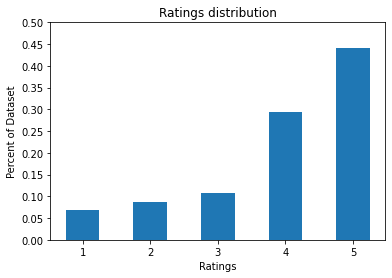

In [6]:
# An example of the distribution of the model 

import matplotlib.pyplot as plt

# Distribution of the ratings
fig, ax = plt.subplots(1,1, figsize=(6,4))

hist, bins = np.histogram(data["Rating"], bins=np.arange(0.5, 6.5, 1))

ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=0.5)
ax.set_xticks([i+0.5 for i in range(5)])
ax.set_xticklabels([str(i+1) for i in range(5)])
ax.set_yticks(np.arange(0, 0.55, 0.05))

ax.set_xlabel("Ratings")
ax.set_ylabel("Percent of Dataset")
ax.set_title("Ratings distribution")

As indicated before, we will split our data into a training/testing branch

In [7]:
# We'll split our training/testing fraction manually

ptrain = 0.8
Ntrain = int(data.shape[0] * ptrain)
Ntest = int(data.shape[0] - Ntrain)

train = data.iloc[:Ntrain, :]
test = data.iloc[Ntrain:, :]

## 2) Building your own custom encoder

**NOTE: In order to run this encoder, you'll need at least 8GB of VRAM and a GPU. 

For our custom encoder, we will use a **masked language model** (MLM). To explain how an MLM works, imagine a sentence like this:

"This hotel is amazing! I loved my stay here, the bed was comfy and everything was perfect!"

We can convert this into a classification problem using MLM as such:

"Label is [MASK]. This hotel is amazing! I loved my stay here, the bed was comfy and everything was perfect!"

The goal would be to predict whether the hidden token is a positive or negative sentiment. To do this, we will construct "placeholder" tokens that represent the hidden label. The model then computes losses to try to predict what hidden token should replace the underlying label. The ground-truth label will be one of the placeholders we setup.

**NOTE** While this technique is not necessarily recommended for classification (in fact, the fine-tuned approach, which is the default encoder of long-form text in MindsDB, tends to generally outperform the MLM strategy), we can still build our own custom encoder to leverage novel pytorch models with diverse loss functions and criteria.

For convenience, we have provided 2 different scripts, `custom_encoder.py` and `mlm_helpers.py`. The `custom_encoder` script provides an example of how to build an MLM for classification, and `mlm_helpers`, as the name suggests, provides a few functions to help construct labels, new vocabulary, and train a model. 

We will show how to integrate this as a separate branch in the lightwood repo, and train with your own encoder of choice.

### 2a) Making the custom encoder files 

The goal of the encoder is to learn a representation. Some encoders can be trained or "tuned" to generate a representation related to a particular label to ensure the representations contain useful information. In this simple example, we will tune the encoder with the target data.

In this case, a representation is a feature vector that translates the "data" space into a format that is usable by a model. The term "feature vector", "representation", and "embedding" will be used interchangeably hence forth.

![This is the caption\label{mylabel}](images/fig1.png)
*Figure 1: A representation will take an arbitrary sentence, like this hotel review, and convert it into some vector that a model can use. How the vector is constructed depends on the modeling of the language.*
<br>

In the following example in ```custom_encoder.py``` we consider the ```MLMEncoder``` class. All base encoders require the following steps:

(1) an ```__init__``` call used to instantitate the details of the encoder. The only required component of this call is to ensure that the encoder knows whether you are tuning the embeddings to the target or not.  

(2) A ```prepare``` call; This sets up the preliminary ground work of tokenizing and training the encoder to the representation of interest. You can think of this as the ***feature extraction step***

(3) An ```encode``` command; this creates a representation/embedding that will be provided downstream to the mixer or predictive model of the piepline .

(4) A ```decode``` step; This steps translated the featurized form back into the original space. For text, we implemented an Exception, as decoding will be tricky (as an aside -one possible option is to decode back into the tokenized space for language generation!)

(5) A ```to``` step; this step enables you to set the model to a different device (CPU/CUDA)

For specific highlights of the custom encoder, see the script available. As a high level overview:

1) The prepare step calls the ```DistilBertForMaskedLanguageModeling``` model and ```DistilBertTokenizerFast``` for the model and tokenizer respectively  

2) It prepares a priming sentence with a "[MASK]" to be predicted, with the help of ```mlm_helpers``` functions.  

3) For each label, it creates a new token "[Ci]" where $i$ represents the label number and resizes it to the tokenizer and the model embedding dimensionality. The goal of the model is to predict which token must appear under the Mask.

4) It trains the MLM to predict the mask from the underlying label for 1 epoch (default)  

5) The encoder creates an embedding by predicting what the underlying mask token is, replacing it in the model input, and then calculating the last hidden-state of the base DistilBert model and presenting the "[CLS]" token.

In order to integrate these changes and run our custom encoder, we need to make some changes to the lightwood repo. Clone your own lightwood repo [here](https://github.com/mindsdb/lightwood). You can use the command ```python setup.py install --user``` to install from the local source.

Make a new branch from the stable by the following command:

```git checkout -b my_branch_name``` 

Now to make your own changes: In ```lightwood/encoders/text``` place your ```custom_encoders.py``` script.

Subsequently, for your helpers file, place it in ```lightwood/encoders/text/helpers```

![This is the caption\label{mylabel}](images/fig2.png)
<br>
*Figure 2: An example of where the files should be*
<br>


Now, we need to provide references for lightwood to access these encoders. Change the ```__init__.py``` file in ```lightwood/encoders/text/``` and import your encoder

![This is the caption\label{mylabel}](images/fig33.png)
<br>
*Figure 3: Import the MLM encoder to the very bottom of this file*
<br>


Last step, we need ensure that text data will be read as this type of encoder. To do so, we'll make one more change. To do this, we will change the ```data_source.py``` file; this is the file that infers what encoder to use, given a particular column type.

In order to do this, go to ```lightwood/api/data_source.py``` and add 2 lines: (a) import your encoder in the beginning of this file and (b) change ```__lookup_encoder_class``` by introducing ```ColumnDataTypes.TEXT: MLMEncoder``` instead of the default, ```PretrainedLang```. This will now enable you to use your custom encoder into the model.

![This is the caption\label{mylabel}](images/fig4.png)
<br>
*Figure 4: Import the MLM Encoder from lightwood's encoders *
<br>


![This is the caption\label{mylabel}](images/fig5.png)
<br>
*Figure 5: Ensure the text column type for text now defaults to our MLM Encoder* 
<br>

To make this simple, we provided 2 repositories to test between these steps. You can ```git checkout default_textenc``` for our default version, or ```git checkout mlm``` for the masked language model implemented.

## 3) Testing your new encoder out!

Using a git command to switch between repos, we can test how the baseline model performs compared to our new version.

Note, the branches we provide are `default_textenc` and `mlm`; you can swap between these two lightwood repos and see how your model fares.


In [8]:
# Create a predictor instance
model = mdb.Predictor(name="text_reviews")

# Train your model!
model.learn(from_data=train, to_predict="Rating", use_gpu=True)

pip3 install mindsdb_native --upgrade


INFO:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db---51d83821-9541-4234-bb11-6859bb465cbd:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:51 - [START] DataExtractor

INFO:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db---51d83821-9541-4234-bb11-6859bb465cbd:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:56 - [END] DataExtractor, execution time: 0.035 seconds

INFO:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db---51d83821-9541-4234-bb11-6859bb465cbd:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:51 - [START] DataCleaner

INFO:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db---51d83821-9541-4234-bb11-6859bb465cbd:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:56 - [END] DataCleaner, execution time: 0.045 seconds

INFO:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db--

/home/natasha/mdb/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/natasha/mdb/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
INFO:root:A single GBM itteration takes 0.1 seconds
INFO:root:Training GBM (<module 'optuna.integration.lightgbm' from '/home/natasha/mdb/lib/python3.8/site-packages/optuna/integration/lightgbm.py'>) with 100 iterations
min_data_in_leaf, val_score: 0.943244: 100%|##########| 5/5 [01:47<00:00, 21.40s/it]
INFO:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db---51d83821-9541-4234-bb11-6859bb465cbd:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/model_interface/lightwood_backend.py:454 - [LightGBMMi

INFO:lightwood.3239:Finished fitting on 2 of 3 subset
INFO:lightwood.3239:Subtest test error: 1.0920781095822651 on subset 3, overall test error: 1.013155738512675
INFO:lightwood.3239:Model predictions and decoding completed
DEBUG:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db---51d83821-9541-4234-bb11-6859bb465cbd:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/model_interface/lightwood_backend.py:328 - We've reached training epoch nr 0 with an accuracy of 55.41% on the testing dataset

INFO:lightwood.3239:Subtest test error: 1.0927695830663045 on subset 3, overall test error: 1.0170532663663228
INFO:lightwood.3239:Model predictions and decoding completed
DEBUG:mindsdb-logger-52b72b30-a229-11eb-a0cc-c99caea855db---51d83821-9541-4234-bb11-6859bb465cbd:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/model_interface/lightwood_backend.py:328 - We've reached training epoch nr 38 with an accuracy of 54.71% on the testing dataset

INFO:l

In [9]:
result = model.predict(test)

INFO:mindsdb-logger-core-logger---:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:51 - [START] DataExtractor

INFO:mindsdb-logger-core-logger---:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:56 - [END] DataExtractor, execution time: 0.016 seconds

INFO:mindsdb-logger-core-logger---:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:51 - [START] DataTransformer

INFO:mindsdb-logger-core-logger---:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:56 - [END] DataTransformer, execution time: 0.010 seconds

INFO:mindsdb-logger-core-logger---:/home/natasha/mdb/lib/python3.8/site-packages/mindsdb_native/libs/phases/base_module.py:51 - [START] ModelInterface

INFO:lightwood.3239:Computing device used: cuda
INFO:lightwood.3239:Model predictions and decoding completed
INFO:mindsdb-logger-core-logger---:/home/natasha/mdb/lib/python3.8/site-p

In [10]:
ypred = result._data["Rating"]
ytrue = test["Rating"].astype(str).tolist()

acc = [ypred[j] == ytrue[j] for j in range(len(ypred))]

print("Accuracy is =", sum(acc)/len(acc))

Accuracy is = 0.565747743352037
